In [5]:
%load_ext autoreload
%autoreload 2

In [1]:
## Importing libraries
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import import_ipynb
import data_preprocessing
import gibbs_sampler
from torch.utils.tensorboard import SummaryWriter
import copy
import numpy as np
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
from torch.nn import functional as F  #for the activation function
import umap
#random.seed(4)

importing Jupyter notebook from data_preprocessing.ipynb
importing Jupyter notebook from gibbs_sampler.ipynb


In [2]:
# learning parameters
batch_size = 128
lr = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
tx = transforms.ToTensor()

In [4]:
features=16
class MultiVAE(nn.Module):
    def __init__(self):
        super(MultiVAE,self).__init__()
        self.gibbs                   = gibbs_sampler.gibbs_sampler()
        #MNISTencoder
        self.MNISTenc1 = nn.Linear(in_features=784,out_features=512)
        self.MNISTenc2 = nn.Linear(in_features=512,out_features=features*2)  
        #SVHNencoder
        # input size: 3 x 32 x 32
        self.SVHNenc1 = nn.Conv2d(in_channels=3, out_channels=2*features, kernel_size=4, stride=2, padding=1)
        # size: 32 x 16 x 16
        self.SVHNenc2 = nn.Conv2d(in_channels=2*features, out_channels=2*features, kernel_size=4, stride=2, padding=1)
        # size: 32 x 8 x 8
        self.SVHNenc3 = nn.Conv2d(in_channels=2*features, out_channels=features, kernel_size=4, stride=2, padding=1)
        # size: 16 x 4 x 4       
        #MNISTdecoder
        self.MNISTdec1 = nn.Linear(in_features=features,out_features=512)
        self.MNISTdec2 = nn.Linear(in_features=512, out_features=784)
        #SVHNeNcoder
        # input size: 16x1x1
        self.SVHNdec0 = nn.ConvTranspose2d(in_channels=features,out_channels=features, kernel_size=4, stride=1, padding=0)
        # input size: 16x4x4
        self.SVHNdec1 = nn.ConvTranspose2d(in_channels=features,out_channels=2*features, kernel_size=3, stride=1, padding=1)
        # size: 32 x 4 x 4
        self.SVHNdec2 = nn.ConvTranspose2d(in_channels=2*features,out_channels=2*features, kernel_size=5, stride=1, padding=0)
        # size: 32 x 8 x 8
        self.SVHNdec3 = nn.ConvTranspose2d(in_channels=2*features,out_channels=2*features, kernel_size=4, stride=2, padding=1)
        # size: 32 x 16 x 16
        self.SVHNdec4 = nn.ConvTranspose2d(in_channels=2*features,out_channels=3, kernel_size=4, stride=2, padding=1)
        # size: 3 x 32 x 32
        
        self.SVHNc1 = nn.Conv2d(features, features, 4, 1, 0)
        # size: 16 x 1 x 1
        self.SVHNc2 = nn.Conv2d(features, features, 4, 1, 0)
        # size: 16 x 1 x 1
    def conditional_plot(self,z):
        y=z.cpu().detach().numpy()
        plt.hist(y,density=True,bins=100,range=(-2,2))
        return
    
    def forward(self,x,xp):
        data=x
        datap=xp
        # encoding for MNIST
        x = F.relu(self.MNISTenc1(x))
        x = self.MNISTenc2(x).view(-1,2,features)
        
        # get 'mu' and 'log_var' for MNIST
        mu = x[:,0,:]
        log_var = x[:,1,:]
        var = torch.exp(log_var)
        #z = self.reparameterize(mu,log_var)
        
        # encoding for SVHN
        xp = xp.view(-1,3, 32,32) 

        xp = F.relu(self.SVHNenc1(xp))
        xp = F.relu(self.SVHNenc2(xp))
        xp = F.relu(self.SVHNenc3(xp))
        
        # get 'mu' and 'log_var' for SVHN
        mup = self.SVHNc1(xp).squeeze(2)
        mup = mup.squeeze(2)
        log_varp = self.SVHNc2(xp).squeeze(2)
        log_varp = log_varp.squeeze(2)        
        varp = torch.exp(log_varp)
        #zp = self.reparameterize(mup,log_varp)
        # size: 64x16
        #zp = zp.unsqueeze(2)
        #zp = zp.unsqueeze(3)
        # size: 64x16 x1 x1
        
        G,z0,zp0,z_prior,zp_prior = self.gibbs.calc(mu,var,mup,varp)
          
    ## Vectorize everythng

        T_prior = torch.cat((z_prior,torch.square(z_prior)),1)        #sufficient statistics for prior of MNIST
        Tp_prior = torch.cat((zp_prior,torch.square(zp_prior)),1)     #sufficient statistics for prior of SVHN
        T_post = torch.cat((z0,torch.square(z0)),1)                   #sufficient statistics for posterior of MNIST
        Tp_post = torch.cat((zp0,torch.square(zp0)),1)                #sufficient statistics for posterior of SVHN
        lambda_0 = torch.cat((mu,var),1)                              #Output of encoder for MNIST
        lambdap_0= torch.cat((mup,varp),1)                            #Output of encoder for SVHN

       
        ## Detaching T
#         T_prior=T_prior.detach()
#         Tp_prior=Tp_prior.detach()
#         T_post=T_post.detach()
#         Tp_post=Tp_post.detach()
        

        part_fun1      = -torch.sum(torch.mul(lambda_0,T_post))-torch.sum(torch.mul(lambdap_0,Tp_post)) #-lambda*Tq-lambda'Tq'
        T_prior_cross  = T_prior.unsqueeze(2)
        Tp_prior_cross = Tp_prior.unsqueeze(2)
        T_post_cross   = T_post.unsqueeze(1)
        Tp_post_cross  = Tp_post.unsqueeze(1)
        
        ## Detaching T
#         T_prior_cross=T_prior_cross.detach()
#         Tp_prior_cross=Tp_prior_cross.detach()
#         T_post_cross=T_post_cross.detach()
#         Tp_post_cross=Tp_post_cross.detach()
        
        part_fun2 = torch.sum(torch.mul(T_prior_cross*Tp_prior_cross,G))-torch.sum(torch.mul(T_post_cross*Tp_post_cross,G))        

        T_prior_sqrd = torch.sum(torch.square(z_prior),1) +torch.sum(torch.square(zp_prior),1) #stores z^2+z'^2
        T_post_sqrd  = torch.sum(torch.square(z0),1) +torch.sum(torch.square(zp0),1)
        ## Detaching T
#         T_prior_sqrd=T_prior_sqrd.detach()
#         T_post_sqrd=T_post_sqrd.detach()
        
    # Sampling from logp(z,z')
        log_p_prior = -T_prior_sqrd+torch.matmul(torch.matmul(T_prior,G),torch.transpose(Tp_prior,0,1))
    # Sampling from log_q(z,z'|x,x')
        log_q_post  = -T_post_sqrd+torch.matmul(torch.matmul(T_post,G),torch.transpose(Tp_post,0,1))
        
        part_fun0=torch.sum(torch.diagonal(log_q_post-log_p_prior,0))
        ## check this zp_prior
        zp0 = zp0.unsqueeze(2)
        zp0 = zp0.unsqueeze(3)
        #zp_prior=zp_prior.unsqueeze(2)
        #zp_prior=zp_prior.unsqueeze(3)
 
        
        

        # decoding for MNIST
        x = F.relu(self.MNISTdec1(z0 ))
        reconstruction = self.MNISTdec2(x)
        
        # decoding for SVHN
        xp = F.relu(self.SVHNdec0(zp0))
        xp = F.relu(self.SVHNdec1(xp))
        xp = F.relu(self.SVHNdec2(xp))
        xp = F.relu(self.SVHNdec3(xp))
        reconstructionp = (self.SVHNdec4(xp)).view(-1,3072)
        
        # calculating loss
        mse_loss = nn.MSELoss(reduction='sum')
        MSE = mse_loss(reconstruction, data)
        MSEp= mse_loss(reconstructionp, datap)
        KLD = -(part_fun0+part_fun1+part_fun2)
        loss= MSE+MSEp+KLD
        
        return z0,zp0,reconstruction, mu, log_var,reconstructionp, mup, log_varp,loss
    
    
    

In [5]:

## Importing MNIST and SVHN datasets
joint_dataset_train=data_preprocessing.JointDataset(mnist_pt_path="/home/achint/Practice_code/VAE/MNIST/MNIST/processed/training.pt",
                             svhn_mat_path="/home/achint/Practice_code/VAE/SVHN/train_32x32.mat")
joint_dataset_test = data_preprocessing.JointDataset(mnist_pt_path="/home/achint/Practice_code/VAE/MNIST/MNIST/processed/test.pt",
                             svhn_mat_path="/home/achint/Practice_code/VAE/SVHN/test_32x32.mat")

joint_dataset_train_loader = DataLoader(
    joint_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
joint_dataset_test_loader = DataLoader(
    joint_dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

#model = model_mnist_SVHN.MultiVAE(device).to(device)
model = MultiVAE().to(device)

optimizer = optim.Adam(model.parameters(),lr=lr)
#writer = SummaryWriter()

In [6]:
def fit(model,joint_dataloader):
    model.train()
    running_loss = 0.0
    for i,joint_data in enumerate(joint_dataloader):
    #for i, data in tqdm(enumerate(MNISTdataloader), position=0, leave=True,total=int(len(train_mnist)/MNISTdataloader.batch_size)):
        data    = joint_data[0]
        data    = data.float()
        datap   = joint_data[1]
        datap   = datap.float()
        data    = data.to(device)
        datap   = datap.to(device)
        data    = data.view(data.size(0), -1)
        datap   = datap.view(datap.size(0), -1)
        optimizer.zero_grad()
        z,zp,reconstruction, mu, logvar,reconstructionp, mup, logvarp,loss = model(data,datap)

        running_loss += loss.item()          #.item converts tensor with one element to number
        loss.backward()                      #.backward
        #clipping_value = 1
        #torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)

        optimizer.step()                     #.step one learning step
    train_loss = running_loss/(len(joint_dataloader.dataset))

    return train_loss
    
def validate(model,joint_dataloader):
    latent_repMNIST= []
    latent_repSVHN= []
    label_mnist= []
    label_svhn= []
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i,joint_data in enumerate(joint_dataloader):
            data   =joint_data[0]
            data = data.float()

            datap  =joint_data[1]
            datap = datap.float()

            label  =joint_data[2]
            labelp =joint_data[3]
            
            data = data.to(device)
            datap= datap.to(device)
            data = data.view(data.size(0), -1)
            datap= datap.view(datap.size(0), -1)
            z,zp,reconstruction, mu, logvar,reconstructionp, mup, logvarp,loss = model(data,datap)
            latent_repMNIST.append(z)
            zp=torch.squeeze(zp)
            latent_repSVHN.append(zp)
            label_mnist.append(label)
            label_svhn.append(labelp)
            running_loss += loss.item()
        
            #save the last batch input and output of every epoch
            if i == int(len(joint_dataloader.dataset)/joint_dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                bothp = torch.cat((datap.view(batch_size, 3, 32, 32)[:8], 
                                  reconstructionp.view(batch_size, 3, 32, 32)[:8]))
                save_image(both.cpu(), f"/home/achint/Practice_code/VAE/output_MNIST_SVHN_coupled/outputMNIST{epoch}.png", nrow=num_rows)
                save_image(bothp.cpu(), f"/home/achint/Practice_code/VAE/output_MNIST_SVHN_coupled/outputSVHN{epoch}.png", nrow=num_rows)
    latent_repMNIST = torch.vstack(latent_repMNIST).cpu().numpy()
    latent_repSVHN  = torch.vstack(latent_repSVHN).cpu().numpy()
    label_mnist = torch.hstack(label_mnist).cpu().numpy()
    label_svhn = torch.hstack(label_svhn).cpu().numpy()
    val_loss = running_loss/len(joint_dataloader.dataset)
    return val_loss,latent_repMNIST,latent_repSVHN,label_mnist,label_svhn

In [7]:
train_loss = []
val_loss = []
epochs = 150
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model,joint_dataset_train_loader)
    val_epoch_loss,latent_repMNIST,latent_repSVHN,label_mnist,label_svhn = validate(model,joint_dataset_test_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)     
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 150
Train Loss: nan
Val Loss: nan
Epoch 2 of 150
Train Loss: nan
Val Loss: nan
Epoch 3 of 150
Train Loss: nan
Val Loss: nan
Epoch 4 of 150


KeyboardInterrupt: 

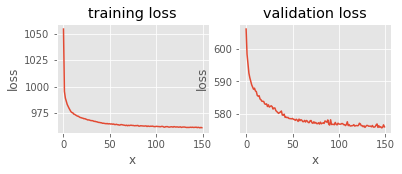

In [108]:
flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
ax1.plot(train_loss)
ax1.set(xlabel='x',ylabel='loss',title='training loss')
ax2.plot(val_loss)
ax2.set(xlabel='x',ylabel='loss',title='validation loss')
fig.tight_layout()
plt.show()

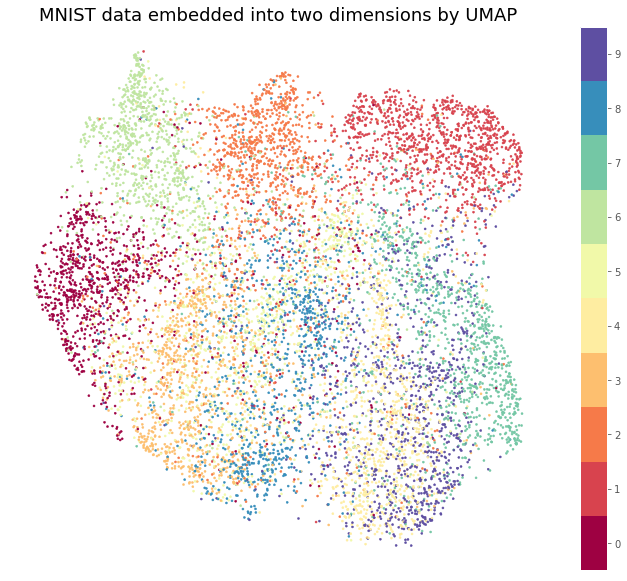

In [109]:
reducer = umap.UMAP()
data=latent_repMNIST
color = label_mnist
#labels=list(mnist_val_loader.dataset.class_to_idx.values())
labels=list(mnist_val_loader.dataset.class_to_idx)

embedding = reducer.fit_transform(data)
fig, ax = plt.subplots(1,figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1],c=color, cmap="Spectral", s=4)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(labels)
cbar.set_ticklabels(np.arange(10))
plt.title("MNIST data embedded into two dimensions by UMAP", fontsize=18)
ax.set_facecolor('white')

plt.show()    

In [65]:
labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

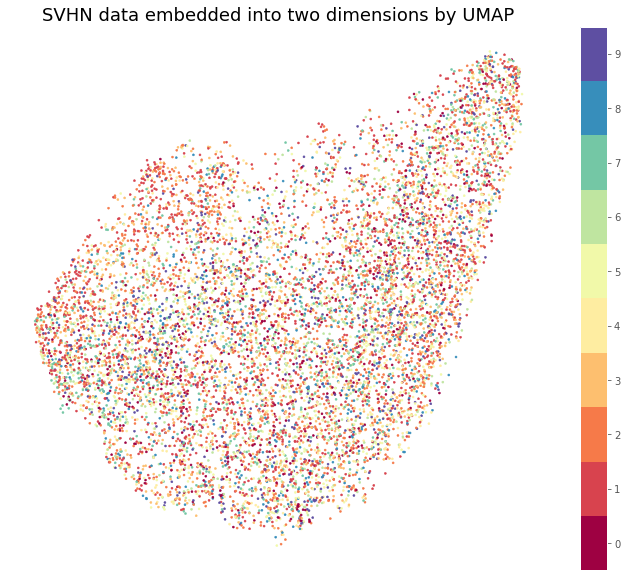

In [110]:
reducer = umap.UMAP()
data=latent_repSVHN
color = label_svhn
labels=list(svhn_val_loader.dataset.labels.numpy())

embedding = reducer.fit_transform(data)
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1],c=color, cmap="Spectral", s=4)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(labels)
cbar.set_ticklabels(np.arange(10))

plt.title("SVHN data embedded into two dimensions by UMAP", fontsize=18)
ax.set_facecolor('white')

plt.show()

In [69]:
label_svhn[0]

5

In [70]:
labels[0]

5

In [23]:
for name,parameters in model.named_parameters():
    print(name)

MNISTenc1.weight
MNISTenc1.bias
MNISTenc2.weight
MNISTenc2.bias
SVHNenc1.weight
SVHNenc1.bias
SVHNenc2.weight
SVHNenc2.bias
SVHNenc3.weight
SVHNenc3.bias
MNISTdec1.weight
MNISTdec1.bias
MNISTdec2.weight
MNISTdec2.bias
SVHNdec0.weight
SVHNdec0.bias
SVHNdec1.weight
SVHNdec1.bias
SVHNdec2.weight
SVHNdec2.bias
SVHNdec3.weight
SVHNdec3.bias
SVHNdec4.weight
SVHNdec4.bias
SVHNc1.weight
SVHNc1.bias
SVHNc2.weight
SVHNc2.bias
